# **Recurrent Neural Networks**

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

There are different ways to implement RNN models.

First, let’s implement a very simple RNN model, without using any of TensorFlow’s
RNN operations, so called "Manual RNN", to better understand what goes on under the hood. 

We will create an RNN composed of a layer of five recurrent neurons, shown in sldide 18 of Session 8, using the tanh activation function. We will assume that the RNN runs
over only two time steps, taking input vectors of size 3 at each time step. The following code builds this RNN, unrolled through two time steps:



## Manual RNN

In [3]:
# Graph Construction at first

reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs]) # two time steps, t=0 and t=1
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32)) # weighht for X
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32)) # weight for Y
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

# using function tanh() to actavite output Y

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)  # t=0
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b) # at t=1

init = tf.global_variables_initializer()

This network looks much like a two-layer (one as hidden layer, another as output layer) feedforward neural network, with a few
twists: first, the same weights and bias terms are shared by both layers, and second,
we feed inputs at each layer, and we get outputs from each layer. 

To run the model, we need to feed it the inputs at both time steps, like so:

In [4]:
# execute or run graph

import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0, feed 4 instances 
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

This mini-batch contains four instances, each with an input sequence composed of
exactly two inputs. 

At the end, Y0_val and Y1_val contain the outputs of the network
at both time steps for all neurons and all instances in the mini-batch:

In [5]:
print(Y0_val) 
# output at t=0
# five neurons, so we have five outputs in columns

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210421  0.6280527   0.9671843  -0.9937122  -0.25839362]
 [ 0.9999983  -0.9999994  -0.9999975  -0.8594331  -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


That wasn’t too hard, but of course if you want to be able to run an RNN over 100
time steps, the graph is going to be pretty big. 

Now let’s look at how to create the same model using TensorFlow’s RNN operations.

## Using `static_rnn()`

The static_rnn() function creates an unrolled RNN network by chaining cells. The
following code creates the exact same model as the previous one:

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
# create graph at first

reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

First we create the input placeholders, as before. Then we create a BasicRNNCell ,
which you can think of as a factory that creates copies of the cell to build the unrolled
RNN (one for each time step). 


Then we call static_rnn() , giving it the cell factory and the input tensors, and telling it the data type of the inputs (this is used to create the initial state matrix, which by default is full of zeros). 

The static_rnn() function calls the cell factory’s __call__() function once per input, creating two copies of the cell (each containing a layer of five recurrent neurons), with shared weights and bias terms, and it chains them just like we did earlier. The static_rnn() function returns
two objects. 

The first is a Python list containing the output tensors for each time step.
The second is a tensor containing the final states of the network. When you are using
basic cells, the final state is simply equal to the last output.

In [9]:
# then, we evalute the graph

init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542542 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.9997605 , -0.06679298, -0.9999804 ,  0.99982214],
       [-0.6524944 , -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.998624  , -0.997152  , -0.03308626, -0.9991565 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660636, -0.8307605 ,  0.7967197 ]],
      dtype=float32)

## Packing sequences

If there were 50 time steps, it would not be very convenient to have to define 50 input
placeholders and 50 output tensors. Moreover, at execution time you would have to feed each of the 50 placeholders and manipulate the 50 outputs. 


Let’s simplify this.
The following code builds the same RNN again, but this time it takes a single input
placeholder of shape [None, n_steps, n_inputs] where the first dimension is the
mini-batch size. Then it extracts the list of input sequences for each time step. X_seqs
is a Python list of n_steps tensors of shape [None, n_inputs] , where once again the
first dimension is the mini-batch size. 

To do this, we first swap the first two dimensions using the transpose() function, so that the time steps are now the first dimension. Then we extract a Python list of tensors along the first dimension (i.e., one tensor per time step) using the unstack() function. The next two lines are the same as before. 

Finally, we merge all the output tensors into a single tensor using the
stack() function, and we swap the first two dimensions to get a final outputs tensor of shape [None, n_steps, n_neurons] (again the first dimension is the mini-batch size).




In [13]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [14]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [15]:
init = tf.global_variables_initializer()

In [16]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [17]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94288003 -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971031  -0.9964609 ]
  [-0.637116    0.11300932  0.5798437   0.43105593 -0.63716984]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.89605415  0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746334 -0.73191994  0.7827872   0.9525682  -0.97817713]]]


In [18]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.9998869   0.94055814  0.9999985  -0.9999997 ]
 [-0.637116    0.11300932  0.5798437   0.43105593 -0.63716984]
 [-0.9165386  -0.9945604   0.89605415  0.99987197 -0.9999751 ]
 [-0.02746334 -0.73191994  0.7827872   0.9525682  -0.97817713]]


## Using `dynamic_rnn()`

The dynamic_rnn() function uses a while_loop() operation to run over the cell the
appropriate number of times, and you can set swap_memory=True if you want it to
swap the GPU’s memory to the CPU’s memory during backpropagation to avoid
OOM errors. 

Conveniently, it also accepts a single tensor for all inputs at every time
step (shape [None, n_steps, n_inputs] ) and it outputs a single tensor for all out‐
puts at every time step (shape [None, n_steps, n_neurons] ); there is no need to
stack, unstack, or transpose. The following code creates the same RNN as earlier
using the dynamic_rnn() function. It’s so much nicer!

For example:



In [19]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [20]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # calling dynamic_rnn()

In [21]:
init = tf.global_variables_initializer()

In [22]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [23]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.9999959   0.9999958   0.9981815   1.          0.37679598]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.2519265 ]
  [-0.70818055 -0.07723375 -0.8522789   0.5845348  -0.7878095 ]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159071 ]
  [-0.9993956   0.9984095   0.83422637  0.9999999  -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.91345143  0.36009577  0.7624866   0.99817705  0.80142   ]]]


## Setting the sequence lengths

So far we have used only fixed-size input sequences (all exactly two steps long). 

What if the input sequences have variable lengths (e.g., like sentences)? In this case you
should set the sequence_length parameter when calling the dynamic_rnn() (or
static_rnn() ) function; it must be a 1D tensor indicating the length of the input
sequence for each instance. 

For example:

In [24]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [25]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [26]:
init = tf.global_variables_initializer()

In [27]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [28]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [29]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.9567259   0.99831694  0.99970174  0.9651857 ]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.9366201 ]
  [-0.9999526   0.9681953   0.9600286   0.9870625   0.8545923 ]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.71322876  0.97729224 -0.09582978]]]


In [30]:
print(states_val)

[[-1.          0.9567259   0.99831694  0.99970174  0.9651857 ]
 [-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.9681953   0.9600286   0.9870625   0.8545923 ]
 [-0.9613586   0.9568762   0.71322876  0.97729224 -0.09582978]]


# Training RNNs

To train an RNN, the trick is to unroll it through time and then simply use regular backpropagation, as lectured. This strategy is called backpropagation through time (BPTT).

## Training a sequence classifier

Let’s train an RNN to classify MNIST images. 

A convolutional neural network would be better suited for image classification as discussed in the lecture, but this makes for a simple example that you are already familiar with. 

We will treat each image as a sequence of 28 rows of 28 pixels each (since each MNIST image is 28 × 28 pixels). 

We will use cells of 150 recurrent neurons, plus a fully connected layer containing 10 neurons
(one per class) connected to the output of the last time step, followed by a softmax
layer (see slide 28 in Session 9 of lecture-notes).

The construction phase is quite straightforward; it’s pretty much the same as the
MNIST classifier as before, except that an unrolled RNN replaces the
hidden layers. 

Note that the fully connected layer is connected to the states tensor,
which contains only the final state of the RNN (i.e., the 28 th output). 

Also note that y is a placeholder for the target classes.

In [31]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Now let’s load the MNIST data and reshape the test data to [batch_size, n_steps,
n_inputs] as is expected by the network. We will take care of reshaping the training
data in a momen

In [32]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Now we are ready to train the RNN. The execution phase is exactly the same as for
the MNIST classifier, except that we reshape each training batch before
feeding it to the network.

In [33]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
        # it takes some time for printing train accuray for 100 batch computing

0 Train accuracy: 0.93333334 Test accuracy: 0.9311
1 Train accuracy: 0.96666664 Test accuracy: 0.9522
2 Train accuracy: 0.97333336 Test accuracy: 0.9586
3 Train accuracy: 0.9533333 Test accuracy: 0.96
4 Train accuracy: 0.96 Test accuracy: 0.9686
5 Train accuracy: 0.98 Test accuracy: 0.9698
6 Train accuracy: 0.98 Test accuracy: 0.971
7 Train accuracy: 0.9866667 Test accuracy: 0.9697
8 Train accuracy: 0.94666666 Test accuracy: 0.9706
9 Train accuracy: 0.97333336 Test accuracy: 0.9712
10 Train accuracy: 0.99333334 Test accuracy: 0.9737
11 Train accuracy: 0.96 Test accuracy: 0.9689
12 Train accuracy: 0.99333334 Test accuracy: 0.9735
13 Train accuracy: 0.97333336 Test accuracy: 0.969
14 Train accuracy: 0.96 Test accuracy: 0.9746
15 Train accuracy: 0.99333334 Test accuracy: 0.9751
16 Train accuracy: 0.9866667 Test accuracy: 0.9741
17 Train accuracy: 0.98 Test accuracy: 0.9748
18 Train accuracy: 0.9866667 Test accuracy: 0.9727
19 Train accuracy: 0.9866667 Test accuracy: 0.9749
20 Train accura

In [34]:
# We get over 98% accuracy—not bad! Plus you would certainly get a better result by
# tuning the hyperparameters, initializing the RNN weights using He initialization,
# training longer, or adding a bit of regularization (e.g., dropout).

# Time series

Now let’s take a look at how to handle time series, such as stock prices, air temperature, brain wave patterns, and so on. 

In this section we will train an RNN to predict the next value in a generated time series. Each training instance is a randomly selected sequence of 20 consecutive values from the time series, and the target sequence is the same as the input sequence, except it is shifted by one time step into the future. 

Please refer to my lecture slides 29 -38 of Session 9.

In [35]:
# First, let'us have a plot for this time-seris

t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


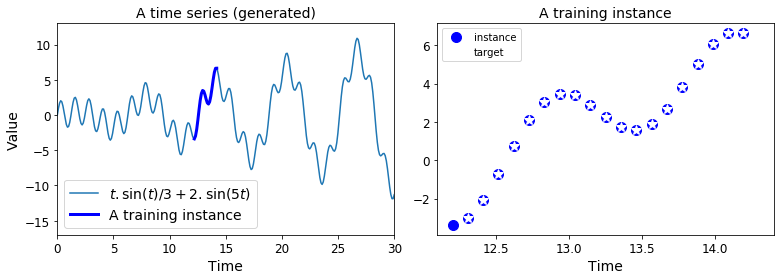

In [36]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [37]:
X_batch, y_batch = next_batch(1, n_steps)

In [38]:
np.c_[X_batch[0], y_batch[0]]

array([[-4.50341339, -4.14236382],
       [-4.14236382, -3.92870702],
       [-3.92870702, -4.0488651 ],
       [-4.0488651 , -4.59566362],
       [-4.59566362, -5.54426493],
       [-5.54426493, -6.75703201],
       [-6.75703201, -8.0161452 ],
       [-8.0161452 , -9.07599852],
       [-9.07599852, -9.72255772],
       [-9.72255772, -9.82515641],
       [-9.82515641, -9.36805638],
       [-9.36805638, -8.45405093],
       [-8.45405093, -7.27923294],
       [-7.27923294, -6.08510771],
       [-6.08510771, -5.09977511],
       [-5.09977511, -4.48258027],
       [-4.48258027, -4.28578062],
       [-4.28578062, -4.44260919],
       [-4.44260919, -4.78464929],
       [-4.78464929, -5.08425773]])

In [39]:
# So, we have got X-bach and Y_bach

## Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [40]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

A cell wrapper acts like a normal cell, proxying every method call to an underlying cell, but it also adds some functionality. The OutputProjectionWrapper adds a fully connected layer of linear neurons (i.e., without any activation function) on top of each output (but it does not affect the cell state).

All these fully connected layers share the same (trainable) weights and bias terms.
The resulting RNN is represented in lecture slide 32 of Section 9.


In [41]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [42]:
# Wrapping a cell is quite easy. Let’s tweak the preceding code by wrapping the
# BasicRNNCell into an OutputProjectionWrapper :

In [43]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [44]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [45]:
# So far, so good. Now we need to define the cost function. We will use the Mean
# Squared Error (MSE), as we did in previous regression tasks. Next we will create an
# Adam optimizer, the training op, and the variable initialization op, as usual:

In [46]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [47]:
saver = tf.train.Saver()

In [48]:
# Now on to the execution phase:

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") 

0 	MSE: 11.9672575
100 	MSE: 0.52584445
200 	MSE: 0.14959829
300 	MSE: 0.07381975
400 	MSE: 0.06171744
500 	MSE: 0.05968452
600 	MSE: 0.055536177
700 	MSE: 0.047983035
800 	MSE: 0.050073363
900 	MSE: 0.04728166
1000 	MSE: 0.047391903
1100 	MSE: 0.048076287
1200 	MSE: 0.040791243
1300 	MSE: 0.0479767
1400 	MSE: 0.04211445


In [49]:
# Once the model is trained, you can make predictions:

with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model")   

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [50]:
y_pred

array([[[-3.406515 ],
        [-2.4501145],
        [-1.1305888],
        [ 0.7817146],
        [ 2.2008858],
        [ 3.138787 ],
        [ 3.399897 ],
        [ 3.3627138],
        [ 2.8842826],
        [ 2.2652197],
        [ 1.650614 ],
        [ 1.5299088],
        [ 1.8965788],
        [ 2.731001 ],
        [ 3.9058359],
        [ 5.14548  ],
        [ 6.144004 ],
        [ 6.6781516],
        [ 6.6523943],
        [ 6.0744486]]], dtype=float32)

Saving figure time_series_pred_plot


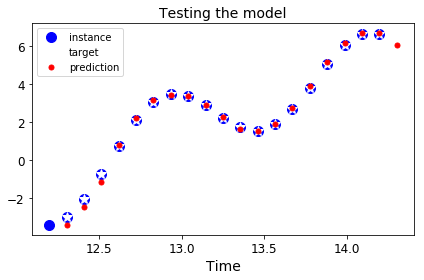

In [51]:
# plot prediction of the time seris

plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

Although using an OutputProjectionWrapper is the simplest solution to reduce the
dimensionality of the RNN’s output sequences down to just one value per time step
(per instance), it is not the most efficient. 


There is a trickier but more efficient solution: you can reshape the RNN outputs from [batch_size, n_steps, n_neurons] to [batch_size * n_steps, n_neurons] , then apply a single fully connected layer with the appropriate output size (in our case just 1), which will result in an output tensor of shape [batch_size * n_steps, n_outputs] , and then reshape this tensor to [batch_size, n_steps, n_outputs] . 

These operations are shown in lecture slide 37 of Sesion 9.



In [52]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [53]:
# To implement this solution, we first revert to a basic cell, 
# without the OutputProjectionWrapper :

In [54]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [55]:
n_outputs = 1
learning_rate = 0.001

In [56]:
# Then we stack all the outputs using the reshape() operation, apply the fully connec‐
# ted linear layer (without using any activation function; this is just a projection), and
# finally unstack all the outputs, again using reshape() :

In [57]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [58]:
# The rest of the code is the same as earlier. This can provide a significant speed boost
# since there is just one fully connected layer instead of one per time step.

In [59]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [60]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907031
100 	MSE: 0.5056713
200 	MSE: 0.20992868
300 	MSE: 0.10282391
400 	MSE: 0.06876178
500 	MSE: 0.061076507
600 	MSE: 0.054797072
700 	MSE: 0.04966834
800 	MSE: 0.050121456
900 	MSE: 0.047807403
1000 	MSE: 0.04775478
1100 	MSE: 0.050040428
1200 	MSE: 0.041216638
1300 	MSE: 0.05031095
1400 	MSE: 0.04354385


In [61]:
y_pred

array([[[-3.4392304 ],
        [-2.4754486 ],
        [-1.1431999 ],
        [ 0.67572594],
        [ 2.2022252 ],
        [ 3.0979629 ],
        [ 3.4667068 ],
        [ 3.317198  ],
        [ 2.856221  ],
        [ 2.2434225 ],
        [ 1.7069325 ],
        [ 1.5460964 ],
        [ 1.8807409 ],
        [ 2.7058399 ],
        [ 3.893656  ],
        [ 5.112901  ],
        [ 6.1083117 ],
        [ 6.658971  ],
        [ 6.645973  ],
        [ 6.051144  ]]], dtype=float32)

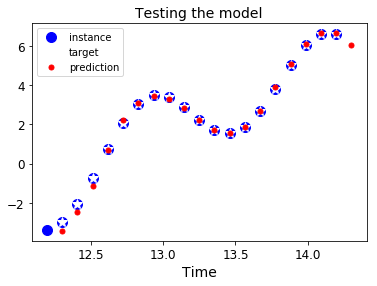

In [62]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

# Generating a creative new sequence (Optional)

Now that we have a model that can predict the future.

All we need is to provide it a seed sequence containing n_steps values (e.g., full of zeros), use the model to predict the next value, append this predicted value to the sequence, feed the last n_steps values to the model to predict the next value, and so on. 

This process generates a new sequence that has some resemblance to the original time series.

In [63]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


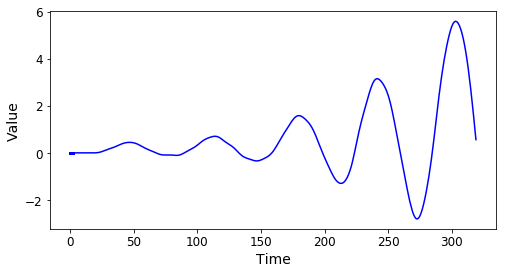

In [64]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


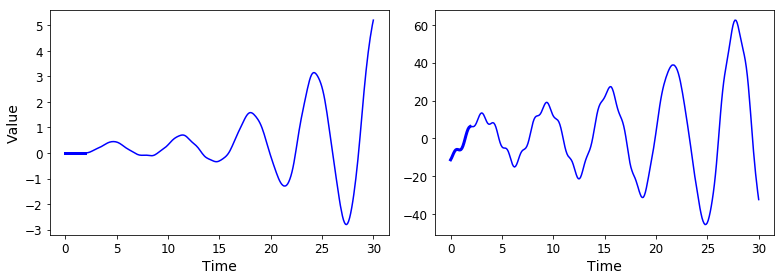

In [65]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()